In [12]:
import os
import sys

project_root = os.path.split(os.getcwd())[0]
print("project_root:", project_root)
if project_root not in sys.path:
    sys.path.append(project_root)
    
os.chdir("/home/kurbanov/deploy/behavox")

project_root: /home/kurbanov/deploy/behavox


In [39]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from laughter_prediction.predictors import MiniXgboostPredictor, StrictLargeXgboostPredictor, AutoMlPredictor, \
    TinyRnnPredictor
from laughter_classification.visualization import plot_ROC_curve
from laughter_classification.visualization import plot_sequence
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, auc

import numpy as np
from scipy.signal import butter, lfilter, freqz
from matplotlib import pyplot as plt
from pandas_ml import ConfusionMatrix

In [16]:
nrows = 50000
features_df = pd.read_csv("features/feaures_pyAA_all_10ms.csv", nrows=nrows)
# features_df = pd.read_csv("../features/feaures_pyAA_all_10ms.csv")

In [17]:
features_df.SNAME.unique()

array(['S1544', 'S0766', 'S2541', 'S1718', 'S1860', 'S0199', 'S0558',
       'S1115', 'S2733', 'S1848', 'S2755', 'S0398', 'S2261', 'S1217',
       'S0131', 'S0475', 'S0842', 'S2043', 'S1724', 'S2516', 'S2312',
       'S0657', 'S1003', 'S2577', 'S1050', 'S1605', 'S2291', 'S1318',
       'S1302', 'S1385', 'S0795', 'S1493', 'S0503', 'S1599', 'S1171',
       'S2085', 'S0064', 'S2216', 'S0411', 'S1877', 'S1749', 'S1121',
       'S2569', 'S1842', 'S0014', 'S0874'], dtype=object)

In [18]:
# some_sname = features_df.SNAME[0]
some_sname = "S0199"
dff = features_df[features_df.SNAME == some_sname]
dff.shape

(1100, 104)

In [19]:
nfeatures = dff.shape[1] - 2
X = dff.iloc[:, :nfeatures].as_matrix()
y = dff.IS_LAUGHTER.as_matrix()

In [20]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [21]:
# https://stackoverflow.com/questions/25191620/
#   creating-lowpass-filter-in-scipy-understanding-methods-and-units
def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a


def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y


In [22]:
def plot_smooth(data, labels, smooth):
    labels = labels / 3 
    n = len(data)
    y = smooth(data)  
    T = 11             # seconds
    t = np.linspace(0, T, n, endpoint=False)

    
    plt.figure(figsize=(50, 30))
    plt.subplot(2, 1, 2)
    plt.plot(t, data, 'b-', label='data')
    plt.plot(t, y, 'g-', linewidth=2, label='filtered data')
    plt.plot(t, labels, 'r-', label='actual data')
#     plt.ylim([0.1, 0.35])

    plt.xlabel('Time [sec]')
    plt.grid()
    plt.legend()

    plt.subplots_adjust(hspace=0.35)
    plt.show()

In [23]:
def simple_smooth(data, n=50):
    dlen = len(data)
    def low_pass(data, i, n):
        if i < n // 2:
            return data[:i]
        if i >= dlen - n // 2 - 1:
            return data[i:]
        return data[i - n//2 : i + n - n//2]
    sliced = np.array([low_pass(data, i, n) for i in range(dlen)])
    sumz = np.array([np.sum(x) for x in sliced])
    return sumz / n


In [24]:
predictor = StrictLargeXgboostPredictor()
predicitons = predictor.predict_proba(X)
plot_smooth(predicitons, y, simple_smooth)

/home/kurbanov/anaconda3/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/home/kurbanov/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


In [25]:
predictor = TinyRnnPredictor()
predicitons = predictor.predict_proba(X)
plot_smooth(predicitons, y, simple_smooth)

1100/1100 [==============================] - 0s     


/home/kurbanov/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


In [26]:
def smart_smooth(data, n=50, p=2):
    dlen = len(data)
    def low_pass(data, i, n):
        if i < n // 2:
            return data[i] * n
        if i >= dlen - n // 2 - 1:
            return data[i] * n
        return np.sum(data[i - n//2 : i + n - n//2])
    sumz = np.array([low_pass(data, i, n) for i in range(dlen)])
#     sumz = np.array([np.sum(x) for x in sliced])
    return 1 / sumz **p  


 960/1100 [=========================>....] - ETA: 0s

/home/kurbanov/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:11: RuntimeWarning: divide by zero encountered in true_divide
/home/kurbanov/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


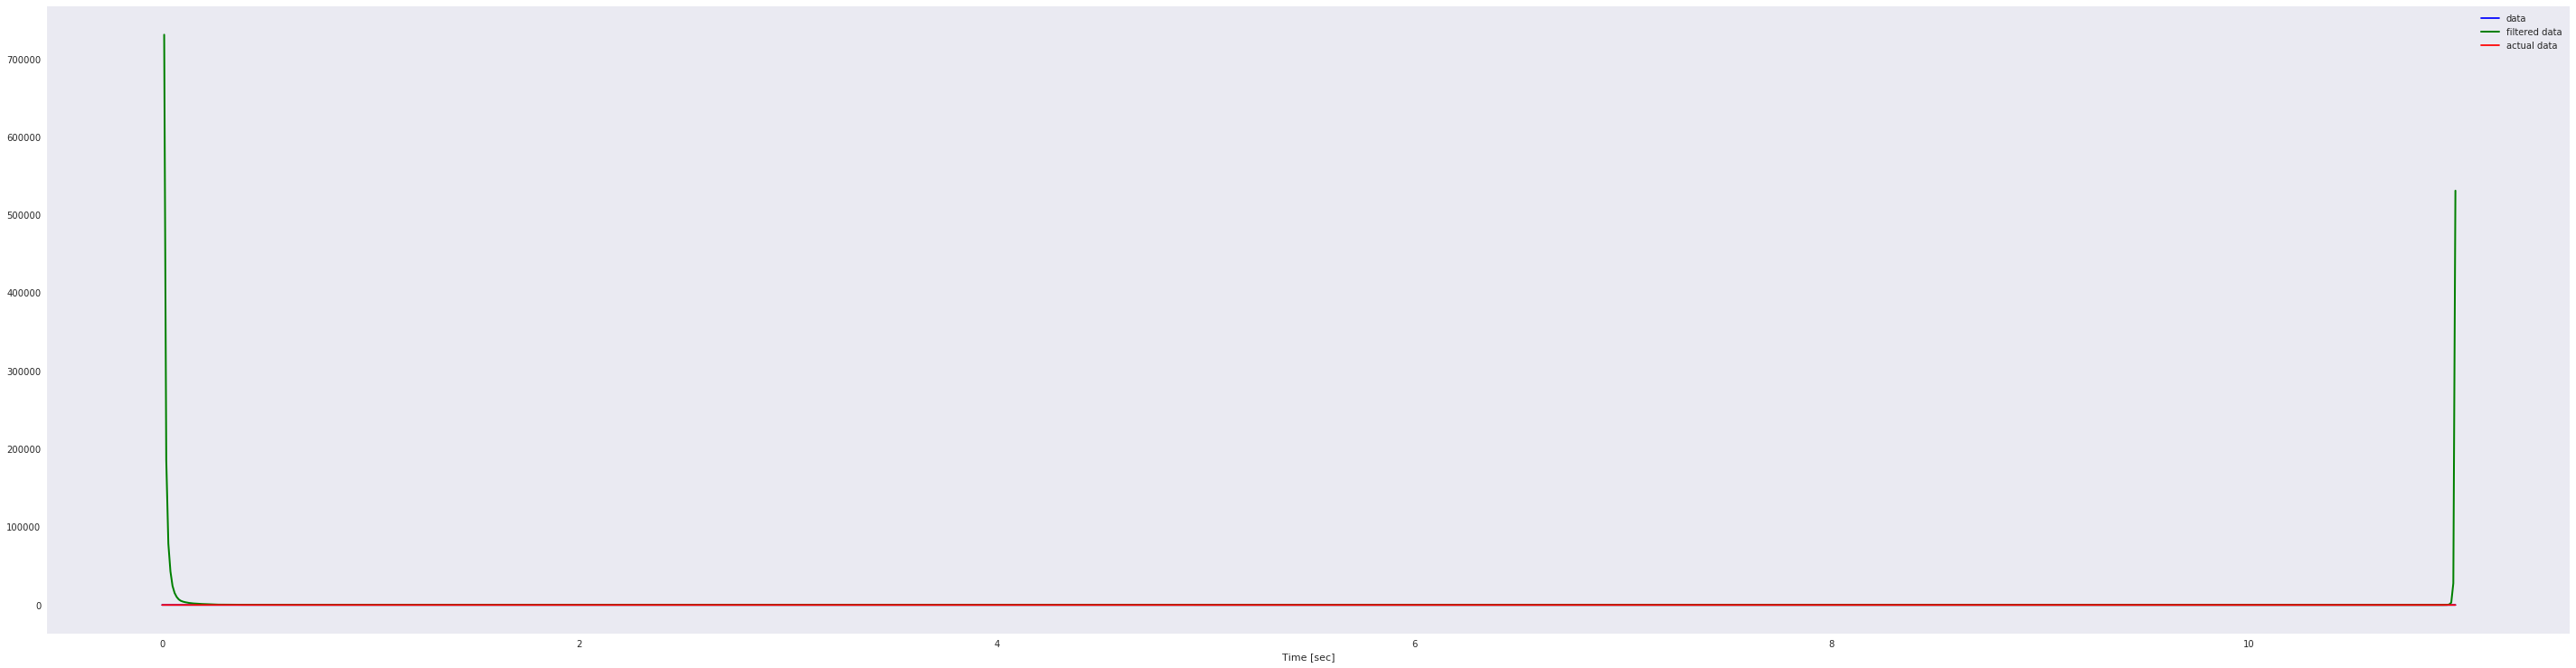

In [27]:
predictor = TinyRnnPredictor()
predicitons = predictor.predict_proba(X)
plot_smooth(predicitons, y, smart_smooth)

In [28]:
nrows = 500000
features_df = pd.read_csv("features/feaures_pyAA_all_10ms.csv", nrows=nrows)
# features_df = pd.read_csv("../features/feaures_pyAA_all_10ms.csv")

In [29]:
features_df.shape

(500000, 104)

In [30]:
nfeatures = dff.shape[1] - 2
X = features_df.iloc[:, :nfeatures].as_matrix()
y = features_df.IS_LAUGHTER.as_matrix()

scaler = StandardScaler()
X = scaler.fit_transform(X)

In [31]:
X.shape

(500000, 102)

In [32]:
predictor = TinyRnnPredictor()
predicitons = predictor.predict_proba(X)
plot_ROC_curve(predicitons, y)

499904/500000 [============================>.] - ETA: 0s

/home/kurbanov/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


In [33]:
fpr, tpr, thresholds = roc_curve(y, predicitons)
roc_auc = auc(fpr, tpr)

In [34]:
thresholds[tpr >= 0.6][0]

0.032216083

/home/kurbanov/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


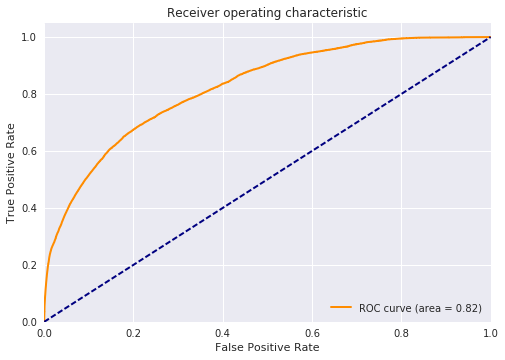

In [35]:
predictor = TinyRnnPredictor()
# predicitons = predictor.predict_proba(X)
smooth_predicitons = simple_smooth(predicitons)
plot_ROC_curve(smooth_predicitons, y)

In [36]:
fpr, tpr, thresholds = roc_curve(y, smooth_predicitons)
roc_auc = auc(fpr, tpr)

In [37]:
thresholds[tpr >= 0.6][0]

0.03329942

/home/kurbanov/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


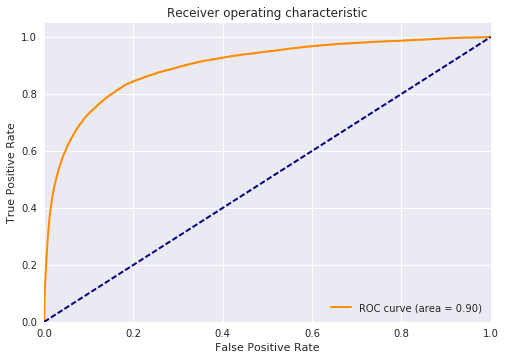

In [117]:
predictor = StrictLargeXgboostPredictor()
xgb_predicitons = predictor.predict_proba(X)
plot_ROC_curve(xgb_predicitons, y)

/home/kurbanov/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


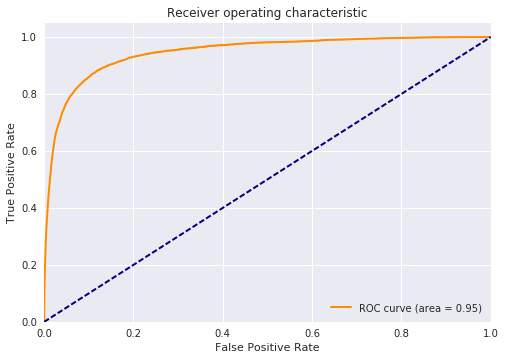

In [119]:
predictor = StrictLargeXgboostPredictor()
xgb_predicitons = predictor.predict_proba(X)
xgb_smooth_predicitons = simple_smooth(xgb_predicitons)
plot_ROC_curve(xgb_smooth_predicitons, y)

In [135]:
fpr, tpr, thresholds = roc_curve(y, xgb_predicitons)
roc_auc = auc(fpr, tpr)

In [136]:
thresholds[tpr >= 0.8][0]

0.045985743

In [50]:
def print_metrics(pred, actual):
    binary_confusion_matrix = ConfusionMatrix(actual, pred)
    print(binary_confusion_matrix, end="\n\n")
    
    print("ACC:", sklearn.metrics.accuracy_score(pred, actual))
    print("PREC:", sklearn.metrics.precision_score(pred, actual))
    print("RECALL:", sklearn.metrics.recall_score(pred, actual))

In [51]:
# bin_pred = TinyRnnPredictor().predict(X)
print_metrics(bin_pred, y)

Predicted     0.0    1.0  __all__
Actual                           
0.0        450723  33163   483886
1.0          9319   6795    16114
__all__    460042  39958   500000

ACC: 0.915036
PREC: 0.421683008564
RECALL: 0.170053556234


In [52]:
bin_pred_xgb = StrictLargeXgboostPredictor().predict(X)
print_metrics(bin_pred_xgb, y)

Predicted     0.0    1.0  __all__
Actual                           
0.0        410930  72956   483886
1.0          3222  12892    16114
__all__    414152  85848   500000

ACC: 0.847644
PREC: 0.80004964627
RECALL: 0.150172397726
